# Lab 2 Gamma Ray & Muon
## Gamma Ray Stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.optimize, scipy.signal
from numpy.polynomial import polynomial as P

In [26]:
data = pd.read_csv(r'co_60_caliobration_data.csv', skiprows = 22)
data = data.iloc[:, 0::2]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

def gaussian_regression(x, y):
    """
    Performs Gaussian regression on data using scipy.optimize.curve_fit.
    
    Parameters:
    -----------
    x : ndarray
        Independent variable (x-coordinates)
    y : ndarray
        Dependent variable (y-coordinates)
    
    Returns:
    --------
    dict : Contains parameters, uncertainties, and fit quality metrics
    """
    
    def gaussian(x, amplitude, center, sigma, offset):
        return amplitude * np.exp(-((x - center) ** 2) / (2 * sigma ** 2)) + offset
    
    amplitude_guess = np.max(y) - np.min(y)
    center_guess = x[np.argmax(y)]
    sigma_guess = (np.max(x) - np.min(x)) / 4
    offset_guess = np.min(y)
    
    p0 = [amplitude_guess, center_guess, sigma_guess, offset_guess]
    
    try:
        popt, pcov = curve_fit(gaussian, x, y, p0=p0, maxfev=10000)
        
        perr = np.sqrt(np.diag(pcov))
        
        y_fit = gaussian(x, *popt)
        residuals = y - y_fit
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        print("="*60)
        print("GAUSSIAN REGRESSION RESULTS")
        print("="*60)
        print(f"Amplitude:  {popt[0]:.6f} ± {perr[0]:.6f}")
        print(f"Center:     {popt[1]:.6f} ± {perr[1]:.6f}")
        print(f"Sigma:      {popt[2]:.6f} ± {perr[2]:.6f}")
        print(f"Offset:     {popt[3]:.6f} ± {perr[3]:.6f}")
        print(f"\nR² value:   {r_squared:.6f}")
        print("="*60)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        x_smooth = np.linspace(np.min(x), np.max(x), 300)
        y_smooth = gaussian(x_smooth, *popt)
        
        ax1.scatter(x, y, label='Data', alpha=0.6, s=50)
        ax1.plot(x_smooth, y_smooth, 'r-', label='Gaussian Fit', linewidth=2)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Gaussian Regression Fit')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.scatter(x, residuals, alpha=0.6, s=50)
        ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax2.set_xlabel('x')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residual Plot')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'parameters': {
                'amplitude': popt[0],
                'center': popt[1],
                'sigma': popt[2],
                'offset': popt[3]
            },
            'uncertainties': {
                'amplitude': perr[0],
                'center': perr[1],
                'sigma': perr[2],
                'offset': perr[3]
            },
            'r_squared': r_squared,
            'covariance': pcov
        }
        
    except RuntimeError as e:
        print(f"Curve fitting failed: {e}")
        return None

GAUSSIAN REGRESSION RESULTS
Amplitude:  919.020939 ± 19.534435
Center:     919.891854 ± 0.130018
Sigma:      19.779480 ± 0.477971
Offset:     57.198738 ± 21.359335

R² value:   0.991936


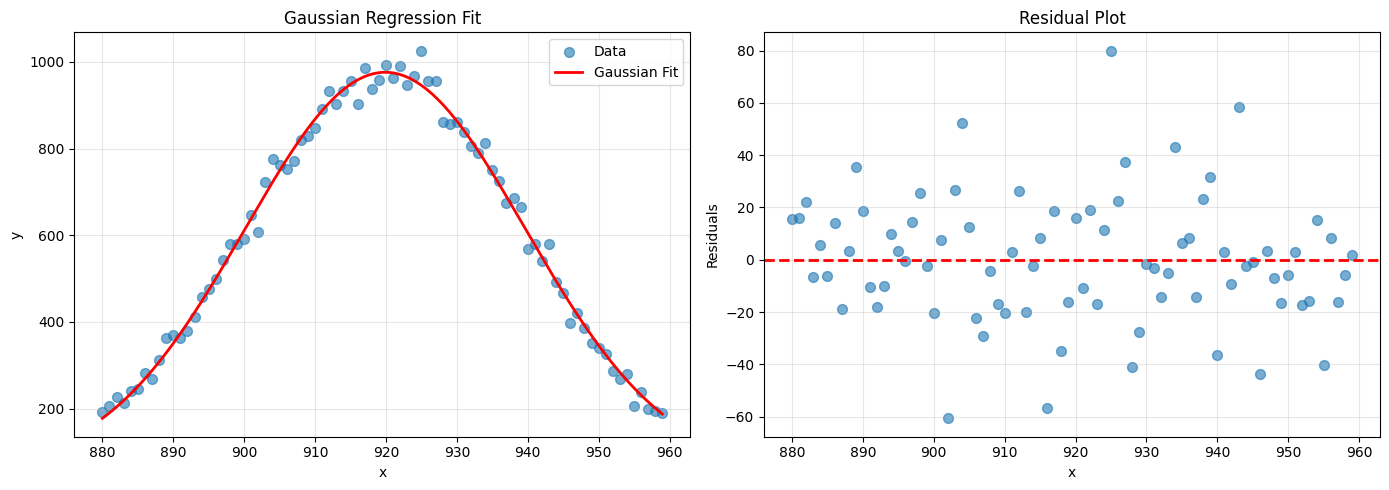

{'parameters': {'amplitude': np.float64(919.020939243493),
  'center': np.float64(919.8918537405267),
  'sigma': np.float64(19.779480158762997),
  'offset': np.float64(57.1987383028277)},
 'uncertainties': {'amplitude': np.float64(19.53443541569497),
  'center': np.float64(0.13001784885915332),
  'sigma': np.float64(0.4779708084792539),
  'offset': np.float64(21.35933467321969)},
 'r_squared': np.float64(0.9919357466094324),
 'covariance': array([[ 3.81594167e+02, -3.99976416e-02,  8.15690185e+00,
         -4.01986657e+02],
        [-3.99976416e-02,  1.69046410e-02, -8.11644217e-04,
          4.32149542e-02],
        [ 8.15690185e+00, -8.11644217e-04,  2.28456094e-01,
         -9.75799369e+00],
        [-4.01986657e+02,  4.32149542e-02, -9.75799369e+00,
          4.56221178e+02]])}

In [37]:
gaussian_regression(np.asarray(data.iloc[880:960,0]),np.asarray(data.iloc[880:960,1]))


GAUSSIAN REGRESSION RESULTS
Amplitude:  1238.459438 ± 19.619216
Center:     811.514820 ± 0.139820
Sigma:      20.315169 ± 0.380349
Offset:     34.884856 ± 21.006922

R² value:   0.992450


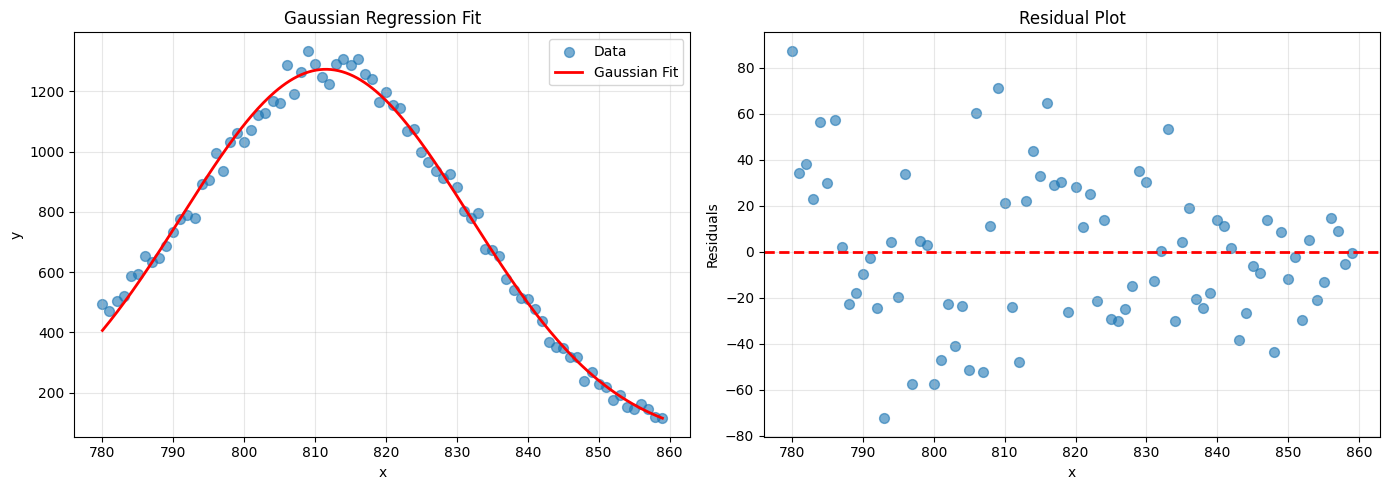

{'parameters': {'amplitude': np.float64(1238.459437517665),
  'center': np.float64(811.5148196985581),
  'sigma': np.float64(20.31516929547062),
  'offset': np.float64(34.88485620636459)},
 'uncertainties': {'amplitude': np.float64(19.61921634257752),
  'center': np.float64(0.1398199340416099),
  'sigma': np.float64(0.3803486189633121),
  'offset': np.float64(21.006922001967126)},
 'r_squared': np.float64(0.9924502902228094),
 'covariance': array([[ 3.84913650e+02,  5.25942706e-01,  5.72186498e+00,
         -3.84616385e+02],
        [ 5.25942706e-01,  1.95496140e-02,  5.37260275e-03,
         -5.25979683e-01],
        [ 5.72186498e+00,  5.37260275e-03,  1.44665072e-01,
         -7.31385656e+00],
        [-3.84616385e+02, -5.25979683e-01, -7.31385656e+00,
          4.41290772e+02]])}

In [38]:
gaussian_regression(np.asarray(data.iloc[780:860,0]),np.asarray(data.iloc[780:860,1]))